In [1]:
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import cv2
from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA

In [15]:
RANDOM_STATE = 111
INPUT_SIZE = 768
HIDDEN_SIZE = 256
OUTPUT_SIZE = 50
BATCH_SIZE = 32
EPOCHS = 50
LR = 1e-6

In [3]:
dir_path = '../data/'

train, train_labels = [], []
with open(dir_path + 'train.txt', 'r') as f:
  for line in f:
    data = line.split(" ")
    train.append(dir_path + data[0])
    train_labels.append(data[1].replace('\n', ''))


val, val_labels = [], []
with open(dir_path + 'val.txt', 'r') as f:
  for line in f:
    data = line.split(" ")
    val.append(dir_path + data[0])
    val_labels.append(data[1].replace('\n', ''))


test, test_labels = [], []
with open(dir_path + 'test.txt', 'r') as f:
  for line in f:
    data = line.split(" ")
    test.append(dir_path + data[0])
    test_labels.append(data[1].replace('\n', ''))

print(f'訓練資料共{len(train)}筆')
print(f'驗證資料共{len(val)}筆')
print(f'測試資料共{len(test)}筆')

訓練資料共63325筆
驗證資料共450筆
測試資料共450筆


### 資料前處理

In [4]:
def data_preprocess(paths):
    features = []
    for path in tqdm(paths):
        # 讀取image，並轉為灰階影像
        img = cv2.imread(path, 0)
        # resize圖片成256*256
        img = cv2.resize(img, (256, 256))
        img = cv2.calcHist(img, [0], None, [64], [0,255])
        # 灰階圖片數值介於0~255之間
        image_normalize = img / 255
        # 轉成一維
        image_flatten = image_normalize.flatten()
        features.append(image_flatten)
        
    return features

def feature_extraction(paths):
    color_features = []
    for path in tqdm(paths):
        img = cv2.imread(path)
        img = cv2.resize(img, (256, 256))
        
        # color histograms彩色直方图
        # 0:blue 1:green 2:red
        color_channels = cv2.split(img)
        bg_features = cv2.calcHist([color_channels[0], color_channels[1]], [0, 1], None, [16, 16], [0, 256, 0, 256]).flatten()
        br_features = cv2.calcHist([color_channels[0], color_channels[2]], [0, 1], None, [16, 16], [0, 256, 0, 256]).flatten()
        gr_features = cv2.calcHist([color_channels[1], color_channels[2]], [0, 1], None, [16, 16], [0, 256, 0, 256]).flatten()
        # 標準化(MaxAbs)，雙色圖片 256*256
        total_features = np.concatenate([bg_features, br_features, gr_features]) / 65536
        color_features.append(total_features)
    return color_features

In [5]:
%%time
# train_features = data_preprocess(train)
# val_features = data_preprocess(val)
# test_features = data_preprocess(test)
train_features = feature_extraction(train)
val_features = feature_extraction(val)
test_features = feature_extraction(test)

  0%|          | 0/63325 [00:00<?, ?it/s]

  0%|          | 0/450 [00:00<?, ?it/s]

  0%|          | 0/450 [00:00<?, ?it/s]

CPU times: user 2min 7s, sys: 3.66 s, total: 2min 11s
Wall time: 2min 17s


### OneHotEncoding

In [6]:
# 轉成np.array再轉成oneHotEncoding
def OneHotEncoding(labels):
    return np.eye(50)[np.array(list(map(int, labels)))]

### shuffle tool

In [7]:
def shuffle(x, y):
    index = np.arange(x.shape[0])
    np.random.shuffle(index)
    return x[index], y[index]

In [8]:
X_train, Y_train = shuffle(np.array(train_features), OneHotEncoding(train_labels))
X_val, Y_val = shuffle(np.array(val_features), OneHotEncoding(val_labels))
X_test, Y_test = shuffle(np.array(test_features), OneHotEncoding(test_labels))

### 評估指標

In [9]:
def top1_acc(labels, pro):
    correct = []
    for i, p in enumerate(pro):
        pred_y = np.argsort(p)[-1]
        if int(labels[i]) == pred_y:
            correct.append(1)
        else:
            correct.append(0)
    
    return round(sum(correct) / len(correct), 4)

def top5_acc(labels, pro):
    correct = []
    for i, p in enumerate(pro):
        top5_y = np.argsort(p)[-5:]
        if int(labels[i]) in list(top5_y):
            correct.append(1)
        else:
            correct.append(0)
    
    return round(sum(correct) / len(correct), 4)

### Activation Function
- relu
- sigmoid
- [softmax](https://zhuanlan.zhihu.com/p/105722023)

In [10]:
class relu():
    def __init__(self):
        self.x = None
    def forward(self, x):
        self.x = x
        return np.maximum(0, self.x)

    def backward(self, delta, weight):
        grad = np.dot(delta, weight)
        grad[self.x <= 0] = 0
        return grad
    
class sigmoid():
    def __init__(self):
        self.x = None
        
    def forward(self, x):
        self.x = x
        return 1.0 / (1.0 + np.exp(-x))

    def backward(self, delta, weight):
        grad = np.dot(delta, weight)
        return grad * self.x * (1-self.x)

class softmax():
    def __init__(self):
        pass
    def forward(self, x):
        # C = np.max(x)
        # z = np.exp(x-C)
        z = np.exp(x)
        return z / np.sum(z, axis=1, keepdims=True)

    def backward(self, y_pred, y_true):
        return y_pred - y_true

### Loss Function

In [11]:
def CrossEntropy(y_pred, y_true):
    # np.seterr(divide = 'ignore')
    # loss = -np.sum(np.multiply(y_true , np.log(y_pred)))
    loss = -np.sum(np.multiply(y_true , np.log(y_pred, where=y_pred>0)))
    return loss

### Two-Layer Perceptron(neural network)
- https://machinelearningmastery.com/implement-backpropagation-algorithm-scratch-python/
- ChatGPT

In [12]:
class TwoLayerPerceptron:
    def __init__(self, input_size, hidden_size, output_size, batch_size, epochs, lr, random_state):
        self.batch_size = batch_size
        self.epochs = epochs
        self.lr = lr
        self.relu = relu()
        self.sigmoid = sigmoid()
        self.softmax = softmax()
        self.w1 = np.random.RandomState(random_state).rand(input_size, hidden_size)
        self.b1 = np.random.RandomState(random_state).rand(hidden_size,)
        self.w2 = np.random.RandomState(random_state).rand(hidden_size, output_size)
        self.b2 = np.random.RandomState(random_state).rand(output_size,)
        # self.w1 = np.random.normal(0, 0.01, (input_size, hidden_size))
        # self.b1 = np.zeros(hidden_size)
        # self.w2 = np.random.normal(0, 0.01, (hidden_size, output_size))
        # self.b2 = np.zeros(output_size)
        
        
    def forward(self, x):
        # 第一層: relu激活函數
        self.s1 = np.dot(x, self.w1) + self.b1
        self.a1 = self.relu.forward(self.s1)
        # self.a1 = self.sigmoid.forward(self.s1)
        # 第二層: softmax計算各類別機率
        self.s2 = np.dot(self.a1, self.w2) + self.b2
        self.y_pred = self.softmax.forward(self.s2)
        return self.y_pred
        
    def backward(self, x, y): 
        # 第二層 upstream gradient
        delta3 = self.softmax.backward(self.y_pred, y) 
        self.dw2 = np.dot(self.a1.T, delta3)
        self.db2 = np.sum(delta3)
        # 第一層
        delta2 = self.relu.backward(delta3, self.w2.T) 
        # delta2 = self.sigmoid.backward(delta3, self.w2.T)
        self.dw1 = np.dot(x.T, delta2)
        self.db1 = np.sum(delta2)
        # 調整WEIGHT, BIAS
        self.step()
    
    def step(self):
        self.w1 -= self.lr * self.dw1
        self.w2 -= self.lr * self.dw2
        self.b1 -= self.lr * self.db1
        self.b2 -= self.lr * self.db2
        
    def train(self, X_train, Y_train, X_val, Y_val):
        loss_list = []
        for epoch in range(self.epochs):
            train_acc = 0
            train_top5_acc = 0
            train_loss = 0
            for i in range(0, len(X_train), self.batch_size):
                X_batch = X_train[i: i + self.batch_size]
                Y_batch = Y_train[i: i + self.batch_size]
                probs = self.forward(X_batch)
                self.backward(X_batch, Y_batch)
                
                # Evaluate the accuracy and loss
                # train_acc += top1_acc(np.argmax(Y_batch, axis=1), np.argmax(probs, axis=1))
                train_acc += accuracy_score(np.argmax(Y_batch, axis=1), np.argmax(probs, axis=1))
                train_top5_acc += top5_acc(np.argmax(Y_batch, axis=1), probs)
                train_loss += CrossEntropy(probs, Y_batch)
            
            # 計算平均準確率及訓練損失
            train_time = math.ceil(len(X_train)/self.batch_size)
            train_acc = train_acc / train_time
            train_top5_acc = train_top5_acc / train_time
            train_loss = train_loss / train_time
            # 計算驗證準確率及損失
            val_probs = self.forward(X_val)
            val_acc =  accuracy_score(np.argmax(Y_val, axis=1), np.argmax(val_probs, axis=1))
            val_top5_acc = top5_acc(np.argmax(Y_val, axis=1), val_probs)
            val_loss = CrossEntropy(val_probs, Y_val)
            
            loss_list.append([train_acc, train_top5_acc, train_loss, val_acc, val_top5_acc, val_loss])
            print(f"Epoch {epoch+1}：\ntrain_acc: {train_acc:.4f} | train_loss: {train_loss:.4f} | val_acc: {val_acc:.4f} | val_loss: {val_loss:.4f}")
            
        return loss_list
    
    def predict(self, X_test, Y_test):
        test_probs = self.forward(X_test)
        test_acc = accuracy_score(np.argmax(Y_test, axis=1), np.argmax(test_probs, axis=1))
        test_top5_acc = top5_acc(np.argmax(Y_test, axis=1), test_probs)
        test_loss = CrossEntropy(test_probs, Y_test)
        print(f"\nTest：\ntest_acc: {test_acc:.4f} | test_top5_acc: {test_top5_acc:.4f} | test_loss: {test_loss:.4f}")
        return [test_acc, test_top5_acc, test_loss]

In [16]:
%%time
# Train the two-layer perceptron
tlp = TwoLayerPerceptron(INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE, BATCH_SIZE, EPOCHS, LR, RANDOM_STATE)
train_result = tlp.train(X_train, Y_train, X_val, Y_val)
test_result = tlp.predict(X_test, Y_test)

Epoch 1：
train_acc: 0.0207 | train_loss: 359.7055 | val_acc: 0.0178 | val_loss: 4023.4805
Epoch 2：
train_acc: 0.0198 | train_loss: 252.6279 | val_acc: 0.0200 | val_loss: 3198.0379
Epoch 3：
train_acc: 0.0194 | train_loss: 211.2058 | val_acc: 0.0222 | val_loss: 2785.2891
Epoch 4：
train_acc: 0.0186 | train_loss: 188.9014 | val_acc: 0.0222 | val_loss: 2545.9018
Epoch 5：
train_acc: 0.0186 | train_loss: 175.2694 | val_acc: 0.0222 | val_loss: 2390.9506
Epoch 6：
train_acc: 0.0187 | train_loss: 166.0427 | val_acc: 0.0267 | val_loss: 2281.2408
Epoch 7：
train_acc: 0.0192 | train_loss: 159.2472 | val_acc: 0.0244 | val_loss: 2197.5917
Epoch 8：
train_acc: 0.0192 | train_loss: 153.9152 | val_acc: 0.0244 | val_loss: 2130.5979
Epoch 9：
train_acc: 0.0192 | train_loss: 149.5789 | val_acc: 0.0244 | val_loss: 2075.7255
Epoch 10：
train_acc: 0.0193 | train_loss: 146.0106 | val_acc: 0.0267 | val_loss: 2030.6805
Epoch 11：
train_acc: 0.0194 | train_loss: 143.0896 | val_acc: 0.0267 | val_loss: 1994.0908
Epoch 12

In [19]:
train_result[-1][3], train_result[-1][4]

(0.024444444444444446, 0.1111)

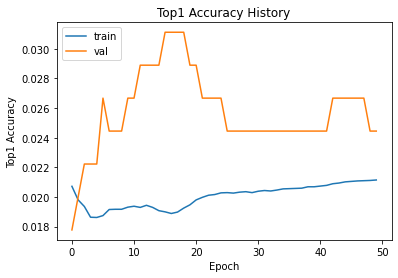

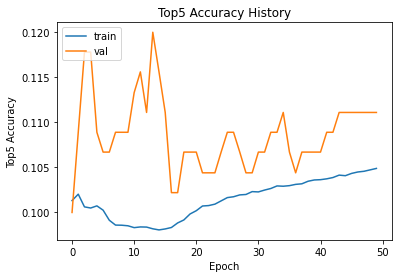

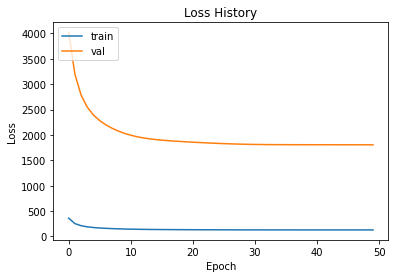

In [17]:
def plot_my_accuracy(train_result):
    plt.plot([x[0] for x in train_result])
    plt.plot([x[3] for x in train_result])
    plt.title('Top1 Accuracy History')
    plt.ylabel('Top1 Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.savefig("top5_acc.png")
    plt.show()

plot_my_accuracy(train_result)

def plot_my_top5_accuracy(train_result):
    plt.plot([x[1] for x in train_result])
    plt.plot([x[4] for x in train_result])
    plt.title('Top5 Accuracy History')
    plt.ylabel('Top5 Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.savefig("top5_acc.png")
    plt.show()
    

plot_my_top5_accuracy(train_result)

def plot_my_loss(train_result):
    plt.clf()
    plt.plot([x[2] for x in train_result])
    plt.plot([x[5] for x in train_result])
    plt.title('Loss History')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.savefig("loss.png")
    plt.show()
    

plot_my_loss(train_result)